<a href="https://colab.research.google.com/github/tosittig/CASAIS/blob/main/Project_2_Sect_3_Assmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Feature Extraction ##Project 2 - Section 3

###List of Tasks


1.   List item
2.   List item




1.   Unfreeze the base model that you froze in Section
1.   Fine-tune the top layers of the base model and train them along with the layers of the classifier you customized in Section 2.
1.   Recompile the model.
1.   Resume training.
1.  Visualise the loss values and compare the performance of the model trained with the feature extraction technique with the performance of the model trained with the fine-tuning technique.

Prepare everything of of section 2 where the kernel has died in the meantime for the 4th time


In [1]:

import tensorflow as tf
import os

# Download the cats & dogs file from a URL with tf.keras.utils.get_file() method
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# get the directory of the file with the os.path.dirname() method, which is /root/keras/datasets
zip_file = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

#combine the paths of the file into one PATH by using the os.path.join() method
PATH = os.path.join(os.path.dirname(zip_file), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')


68606236/68606236 [==============================] - 2s 0us/step


In [2]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                             validation_split=0.3,
                                             subset="training",
                                             seed = 123,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.
Using 1400 files for training.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                             validation_split=0.3,
                                             subset="validation",
                                             seed = 123,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMAGE_SIZE)

Found 1000 files belonging to 2 classes.
Using 300 files for validation.


In [7]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


##Load ResNet50 as the base model.
Load the convolutional base of the ResNet50 model (without th e fully connected layers at the end of that model):

In [8]:
rn50_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 3s 0us/step


freeze the convolutional base, add a fully connected classifier on top

In [13]:
rn50_model.trainable = False

In [14]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling

inputs = tf.keras.Input(shape = (224, 224, 3))

x = Rescaling(scale = 1./127.5, offset = -1)(inputs)
x = rn50_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation ='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

Compile the model (with a Adam Learning rate paramater of 0.0001

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

train the model

In [16]:
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data=validation_dataset)

Epoch 1/10
44/44 [==============================] - 16s 198ms/step - loss: 0.7092 - accuracy: 0.4679 - val_loss: 0.6978 - val_accuracy: 0.4833
Epoch 2/10
44/44 [==============================] - 5s 112ms/step - loss: 0.6968 - accuracy: 0.4807 - val_loss: 0.6884 - val_accuracy: 0.5700
Epoch 3/10
44/44 [==============================] - 5s 113ms/step - loss: 0.6885 - accuracy: 0.5721 - val_loss: 0.6807 - val_accuracy: 0.6133
Epoch 4/10
44/44 [==============================] - 5s 114ms/step - loss: 0.6815 - accuracy: 0.5879 - val_loss: 0.6739 - val_accuracy: 0.6233
Epoch 5/10
44/44 [==============================] - 5s 113ms/step - loss: 0.6759 - accuracy: 0.6071 - val_loss: 0.6682 - val_accuracy: 0.6333
Epoch 6/10
44/44 [==============================] - 5s 115ms/step - loss: 0.6712 - accuracy: 0.6114 - val_loss: 0.6634 - val_accuracy: 0.6367
Epoch 7/10
44/44 [==============================] - 5s 115ms/step - loss: 0.6671 - accuracy: 0.6086 - val_loss: 0.6593 - val_accuracy: 0.6233
Epoch

evaluate the model

In [17]:
model_evaluation = model.evaluate(validation_dataset)

10/10 [==============================] - 1s 90ms/step - loss: 0.6504 - accuracy: 0.6233


In [18]:
model_evaluation = model.evaluate(train_dataset)

44/44 [==============================] - 4s 92ms/step - loss: 0.6564 - accuracy: 0.6329


plot graphs

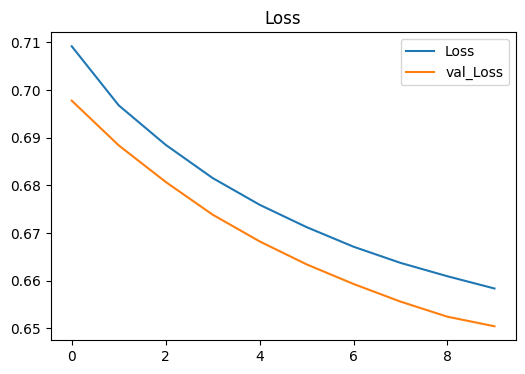

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))


plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss')
plt.legend()

unfreeze the convolutional base and verify the number of layers in it

In [21]:
rn50_model.trainable = True
len(rn50_model.layers)

175

Freeze the first 140 layers of the convolutional base in order to fine-tune only the top 35 layers, which are more specific to the task

In [22]:
fine_tune_at = 120

for layer in rn50_model.layers[0:fine_tune_at]:
  layer.trainable = False

recompile the model

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

resume training for fine tune epochs

In [25]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         validation_data=validation_dataset)


Epoch 1/20
44/44 [==============================] - 22s 211ms/step - loss: 0.7430 - accuracy: 0.5636 - val_loss: 0.6466 - val_accuracy: 0.6300
Epoch 2/20
44/44 [==============================] - 7s 166ms/step - loss: 0.6531 - accuracy: 0.6114 - val_loss: 0.6313 - val_accuracy: 0.6400
Epoch 3/20
44/44 [==============================] - 7s 168ms/step - loss: 0.6458 - accuracy: 0.6393 - val_loss: 0.6234 - val_accuracy: 0.6467
Epoch 4/20
44/44 [==============================] - 7s 168ms/step - loss: 0.6356 - accuracy: 0.6464 - val_loss: 0.6231 - val_accuracy: 0.6533
Epoch 5/20
44/44 [==============================] - 7s 169ms/step - loss: 0.5997 - accuracy: 0.6643 - val_loss: 0.5890 - val_accuracy: 0.6867
Epoch 6/20
44/44 [==============================] - 8s 170ms/step - loss: 0.6160 - accuracy: 0.6514 - val_loss: 0.5895 - val_accuracy: 0.6900
Epoch 7/20
44/44 [==============================] - 8s 171ms/step - loss: 0.5547 - accuracy: 0.7207 - val_loss: 0.5780 - val_accuracy: 0.7233
Epoch

In [26]:
# evaluate the model on the validation dataset

model_evaluation = model.evaluate(validation_dataset)

10/10 [==============================] - 1s 91ms/step - loss: 0.5993 - accuracy: 0.8067


In [27]:
# evaluate the model on the train_dataset

model_evaluation = model.evaluate(train_dataset)

44/44 [==============================] - 4s 92ms/step - loss: 0.1548 - accuracy: 0.9371


In [29]:
# visualise the loss values

loss = history.history['loss']
val_loss = history.history['val_loss']


loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

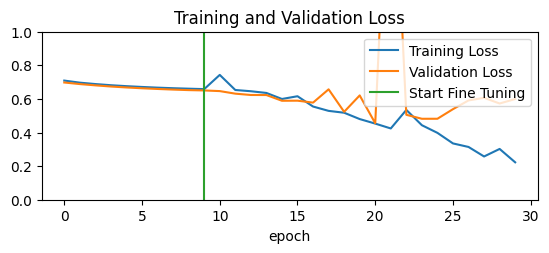

In [30]:

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:

# make predictions

images, labels = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(images).flatten()

In [32]:

# make predictions

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', labels)

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0]


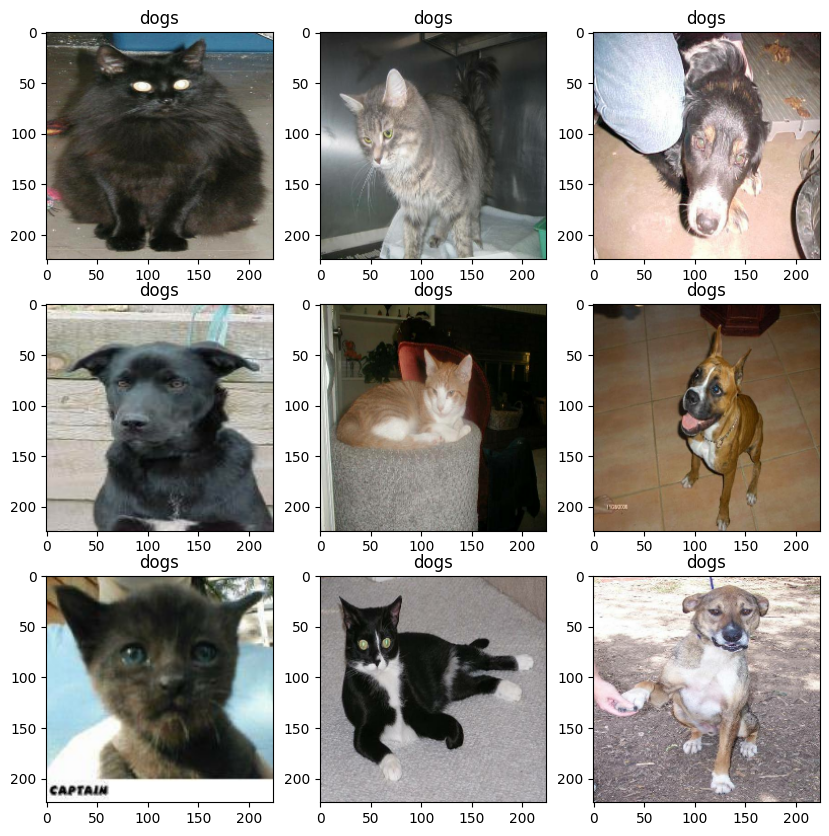

In [33]:

# plot nine predicted images

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].astype("uint8"))
  plt.title(class_names[predictions[i]])